<h1 style="text-align: center;">Simulación y Aplicaciones en Ciencias Sociales y Experimentales
</h3>
<h3 style="text-align: center;"> Práctica 2 </h3>

## Ejercicio 1 

En este ejercicio se propone modelar y simular el proceso de evolución de una epidemia. Los siguientes datos presentan el porcentaje de infectados de una población a lo largo de varias semanas. En el día 0 no había recuperados.  

In [211]:
days = [0, 14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 156, 170, 184]
infected = [0.05, 0.17, 0.05,0.02, 0.01, 0.01, 0.01, 0.02, 0.03, 0.05, 0.04, 0.03, 0.02, 0.01]

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [213]:
def solve_rk(model, x0, t):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n-1):
        dt = t[i+1] - t[i]
        k1 = model(x[i], t[i])
        k2 = model(x[i]+dt*k1/2, t[i]+dt/2)
        k3 = model(x[i]+dt*k2/2, t[i]+dt/2)
        k4 = model(x[i]+dt*k3, t[i]+dt)
        x[i+1] = x[i] + dt/6 * (k1+2*k2+2*k3+k4) 
    return x

**(a)** Tomar un modelo SIR clásico en tiempo continuo (debajo),

$$\begin{aligned}
\frac{ds}{dt} &= -\beta s x, \\
\frac{dx}{dt} &= \beta s x - \gamma x, \\
\frac{dr}{dt} &= \gamma x, \\
\end{aligned}$$ 

donde $s$, $x$ e $r$ son la tasa de susceptibles, infectados y recuperados, respectivamente. Inicialmente, se estima una duración media de la enfermedad de T=10 (por lo que la tasa de recuperación de la enfermedad es $\gamma= 1/T$) y una tasa de difusión de $\beta=0.4$. Re-estimar estos parámetros para que el modelo se ajuste lo mejor posible a los datos. Indicar el error cometido en el ajuste (MAE ó RMSE). 

In [214]:
def sir_model(beta, gamma):
    def f(x, t):
        s = x[0]
        i = x[1]
        return np.array([
            -beta*s*i,
            beta*s*i - gamma*i,
            gamma*i,
        ])
    return f

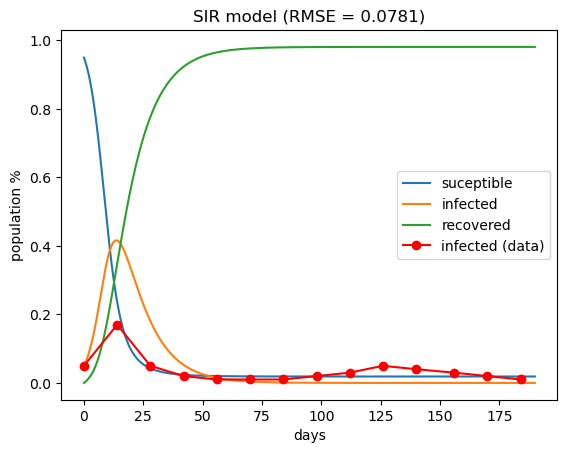

In [215]:
x0 = np.array([1-infected[0], infected[0], 0])
t = np.linspace(0, 190, 1901)

beta = 0.4
gamma = 1/10

x = solve_rk(sir_model(beta, gamma), x0, t)

x_hat = np.interp(days, t, x[:,1])
rmse = np.sqrt(((infected - x_hat)**2).sum() / len(infected))

plt.title(f"SIR model (RMSE = {rmse:.4f})")
plt.plot(t, x, label=["suceptible", "infected", "recovered"])
plt.plot(days, infected, 'ro-', label="infected (data)")
plt.legend()
plt.xlabel("days")
plt.ylabel("population %")
plt.show()

In [216]:
def loss_func(params):
    x = solve_rk(sir_model(*params), x0, t)
    x_hat = np.interp(days, t, x[:,1])
    return x_hat - infected

(beta_hat, gamma_hat), _ = opt.leastsq(loss_func, np.array([beta, gamma]))

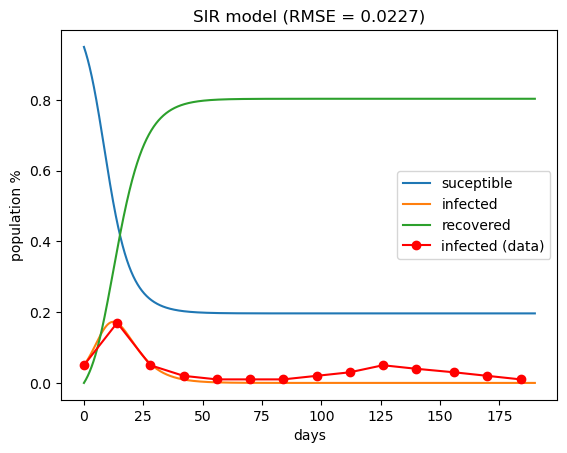

In [217]:
x = solve_rk(sir_model(beta_hat, gamma_hat), x0, t)

x_hat = np.interp(days, t, x[:,1])
rmse = np.sqrt(((infected - x_hat)**2).sum() / len(infected))

plt.title(f"SIR model (RMSE = {rmse:.4f})")
plt.plot(t, x, label=["suceptible", "infected", "recovered"])
plt.plot(days, infected, 'ro-', label="infected (data)")
plt.legend()
plt.xlabel("days")
plt.ylabel("population %")
plt.show()

**(b)** Extender el modelo anterior incluyendo la posibilidad de pérdida de inmunización. Se asume por tanto que los recuperados $r$, pasados una media de $T_p$ días, pasan a ser susceptibles de nuevo. Asumir los parámetros $\beta$, $\gamma$ óptimos calculados en el apartado (a) y $T_p=100$ dias (esto es, una tasa de pérdida de inmunización de $\mu=1/T_p$). Estimar los parámetros $\beta$, $\gamma$ y $\mu$ para los que el modelo se ajusta lo mejor posible a los datos. Indicar si el modelo del apartado (a) o este modelo se ajusta mejor a los datos reales.

In [218]:
def sirs_model(beta, gamma, mu):
    def f(x, *t):
        s = x[0]
        i = x[1]
        r = x[2]
        return np.array([
            mu * r -beta*s*i,
            beta*s*i - gamma*i,
            gamma*i - mu * r,
        ])
    return f

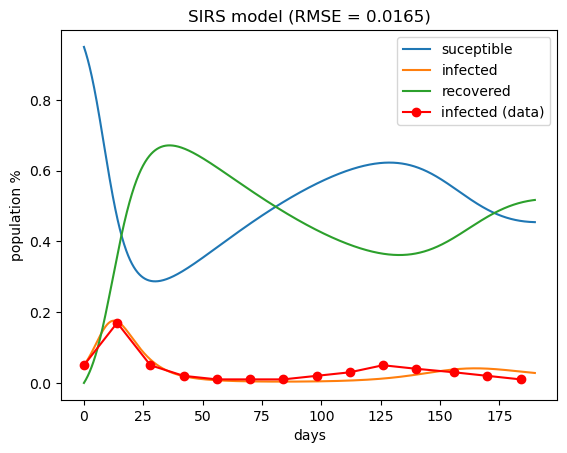

In [219]:
mu = 1/100

x = solve_rk(sirs_model(beta_hat, gamma_hat, mu), x0, t)

x_hat = np.interp(days, t, x[:,1])
rmse = np.sqrt(((infected - x_hat)**2).sum() / len(infected))

plt.title(f"SIRS model (RMSE = {rmse:.4f})")
plt.plot(t, x, label=["suceptible", "infected", "recovered"])
plt.plot(days, infected, 'ro-', label="infected (data)")
plt.legend()
plt.xlabel("days")
plt.ylabel("population %")
plt.show()

In [220]:
def loss_func2(params):
    x = solve_rk(sirs_model(*params), x0, t)
    x_hat = np.interp(days, t, x[:,1])
    return x_hat - infected

(beta_hat_hat, gamma_hat_hat, mu_hat), _ = opt.leastsq(loss_func2, np.array([beta_hat, gamma_hat, mu]))

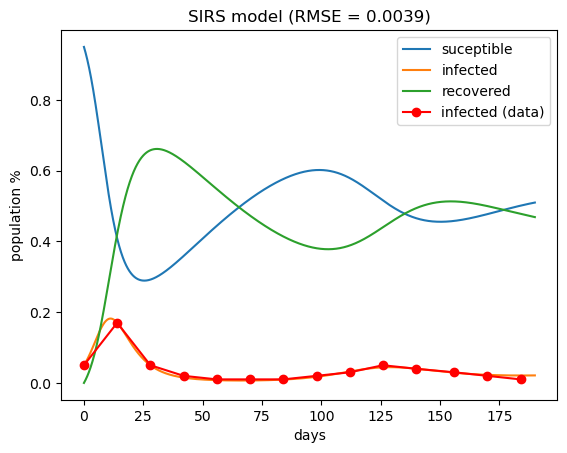

In [221]:
x = solve_rk(sirs_model(beta_hat_hat, gamma_hat_hat, mu_hat), x0, t)

x_hat = np.interp(days, t, x[:,1])
rmse = np.sqrt(((infected - x_hat)**2).sum() / len(infected))

plt.title(f"SIRS model (RMSE = {rmse:.4f})")
plt.plot(t, x, label=["suceptible", "infected", "recovered"])
plt.plot(days, infected, 'ro-', label="infected (data)")
plt.legend()
plt.xlabel("days")
plt.ylabel("population %")
plt.show()

**(c)** Estudiar la sensibilidad de los parámetros del modelo del apartado (b) sobre el pico máximo de infectados en la segunda ola. Indicar qué parámetro tiene el mayor efecto sobre ese pico de infectados.

Se realizará un diseño de experimentos para estudiar la sensibilidad, comparando los parametros dados a priori, con los últimos ajustados de (b)

In [222]:
from scipy import signal


params = {
    "beta": sorted([beta, beta_hat_hat]),
    "gamma": sorted([gamma, gamma_hat_hat]),
    "mu": sorted([mu, mu_hat]),
}

def get_second_peak(x):
    peaks, _ = signal.find_peaks(x[:,1])
    # if no second peak, use last
    if len(peaks) < 2:
        return x[-1, 1]
    else:
        return x[peaks[1], 1]

pn = len(params)
r_x = np.zeros(2**pn)
for si in range(int(2**pn)):
    idxs = [(si >> i & 1) for i in range(pn)]
    cur_param = {
        name: ps[idx]
        for (name, ps), idx
        in zip(params.items(), idxs)
    }
    x = solve_rk(sirs_model(**cur_param), x0, t)
    r_x[si] = get_second_peak(x)

e_x = np.zeros(pn)
for ei in range(pn):
    e_x[ei] = sum(
        r_i if 1 == (i>>ei & 1) else -r_i
        for i, r_i
        in enumerate(r_x)
    ) / 2**(pn-1)

In [119]:
pd.DataFrame(index=params.keys(), data=e_x, columns=["sensibilidad"])

,sensibilidad
beta,0.006007
gamma,-0.054005
mu,0.011411


Segun un analysis factorial $2^k$, el parametro más sensible es gamma,
asociado con la tasa de recuperación de la infección;
con un signo negativo, indicando que cuanto menor es, mayor será la
segunda ola.

Este es seguido por mu, que es la tasa de desimunización.
Dado que este analysis se concentra con la segunda ola, esta dependerá
mucho de que la población perdiese su imunización, dandole tanta importancia
comparado al último parametro de tasa de infección.

Otra interpretación de estas tasas para gamma y mu son el tiempo de recuperación y perdida de imunización, que son reciprocas de estos parametros con lo que sus efectos son en sentido contrario: cuanto mayor
es el tiempo de recuperación, mayor sera la segunda ola, y cuanto menor
sea el tiempo de perdida de imunidad, mayor sera la segunda ola.

In [120]:
beta_range = np.linspace(0.01, 1, 100)
gamma_range = np.linspace(0.01, 1, 100)
mu_range = np.linspace(0.01, 1, 100)

res_beta = np.zeros(100)
res_gamma = np.zeros(100)
res_mu = np.zeros(100)

for i, b in enumerate(beta_range):
    x = solve_rk(sirs_model(b, gamma_hat_hat, mu_hat), x0, t)
    res_beta[i] = get_second_peak(x)
for i, g in enumerate(gamma_range):
    x = solve_rk(sirs_model(beta_hat_hat, g, mu_hat), x0, t)
    res_gamma[i] = get_second_peak(x)
for i, m in enumerate(mu_range):
    x = solve_rk(sirs_model(beta_hat_hat, gamma_hat_hat, m), x0, t)
    res_mu[i] = get_second_peak(x)


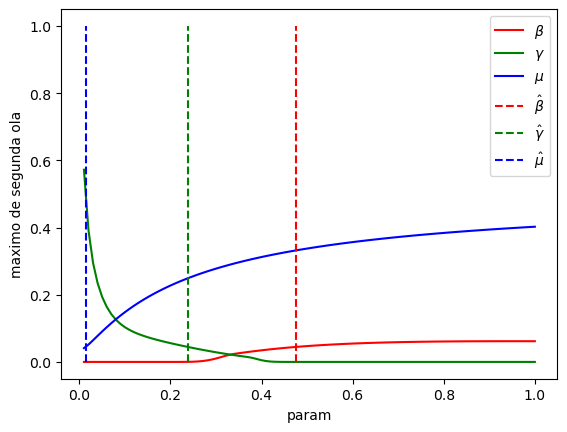

In [121]:
plt.plot(beta_range, res_beta, 'r', label=r"$\beta$")
plt.plot(gamma_range, res_gamma, 'g', label=r"$\gamma$")
plt.plot(mu_range, res_mu, 'b', label=r"$\mu$")
plt.xlabel(r"param")
plt.ylabel("maximo de segunda ola")
plt.vlines(beta_hat_hat, 0, 1, 'r', '--', label=r"$\hat{\beta}$")
plt.vlines(gamma_hat_hat, 0, 1, 'g', '--', label=r"$\hat{\gamma}$")
plt.vlines(mu_hat, 0, 1, 'b', '--', label=r"$\hat{\mu}$")
plt.legend()
plt.show()

**(d)** Para el modelo del apartado (b), calcular por medio de las simulaciones (o analíticamente si se prefiere) el punto de equilibrio al que tienden las trayectorias. Indicar si el punto de equilibrio es estable o inestable. Observando la trayectoria de las variables, los valores propios de la matriz jacobiana en el punto de equilibrio, ¿tienen parte imaginaria distinta de cero?, ¿qué signo tiene la parte real de esos valores propios? 

In [223]:
from sympy import symbols, Eq, solve

s, i, r = symbols("s i r", real=True, positive=True)

eq1 = Eq(mu_hat*r - beta_hat_hat*s*i, 0)
eq2 = Eq(beta_hat_hat*s*i - gamma_hat_hat*i, 0)
eq3 = Eq(gamma_hat_hat*i - mu_hat*r, 0)

x_stars = solve([eq1, eq2, eq3], [s,i,r])
x_stars

[(0.501726619726602, 0.0577579584213869*r, r)]

el resultado es en relación a r, pero se puede fijar un punto concreto si se tiene en cuenta que las 3 variables deben sumarse a 1.

In [224]:
a = float(x_stars[0][0])
b = float(x_stars[0][1].coeff(r))

x_star = (
    a,
    (1-a) * (b/(1+b)),
    (1-a) * (1/(1+b))
)
sum(x_star), x_star

(1.0, (0.5017266197266019, 0.027207786952759393, 0.47106559332063863))

In [126]:
eps = np.sqrt(np.finfo(float).eps)
J = opt.approx_fprime(x_star, sirs_model(beta_hat_hat, gamma_hat_hat, mu_hat), eps)

In [127]:
np.linalg.eig(J).eigenvalues

array([-1.33454847e-02+0.05550091j, -1.33454847e-02-0.05550091j,
        1.97996730e-18+0.j        ])

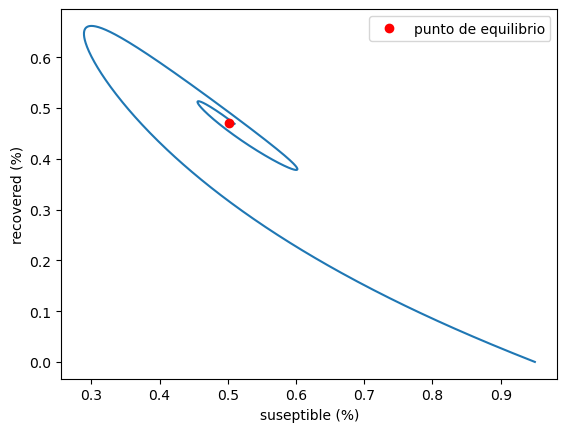

In [134]:
x = solve_rk(sirs_model(beta_hat_hat, gamma_hat_hat, mu_hat), x0, t)

plt.plot(x[:,0], x[:,2])
plt.plot(x_star[0], x_star[2], 'ro', label="punto de equilibrio")
plt.xlabel("suseptible (%)")
plt.ylabel("recovered (%)")
plt.legend()
plt.show()

En los valores propios de la jacobiana, estos son muy cercanos a 0 con componentes imaginarias, que corresponde a la convergencia en forma de espiral observada cuando se pinta la trayectoria en un diagrama de fases.

## Ejercicio 2 <font size=1.5>  <font>

Partimos del modelo económico de la telaraña. Recuérdense los supuestos iniciales:  

- $D(p_t)$ es el producto demandado en el año $t$, que depende del precio $p_t$ del producto en ese año. Se asume una demanda lineal, por tanto, $D(p_t) = a -bp_t$, donde $a$ y $b$ son parámetros.
- Los productores toman decisiones de producción a partir de unas expectativas de precios $p_t^e$. Por tanto, la función de oferta es $S=S(p_t^e)$.
- Se asume un mercado en competencia perfecta, por lo que el precio del producto en cada año se obtiene como resultado de igualarse las funciones de oferta y demanda, esto es $D(p_t)=S(p_t^e)$. Despejando $p_t$ de esta ecuación se llega a:

$$ p_t= \frac{a}{b} - \frac{S(p_t^e)}{b} $$


In [266]:
def solve_disc(model, x0, n):
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n-1):
        x[i+1] = model(x[i])
    return x

In [267]:
def cobweb_model(a,b,c,d):
    def f(x):
        return np.array([(a-c)/b - d*x[0]/b])
    return f

**(a)** Asumimos el caso clásico en el que los productores esperan que el precio del periodo anterior se va a mantener, esto es $p_t^e=p_{t-1}$. Se asume que $p_0=2$ y los valores iniciales de los parámetros $a=14$, $b=2$, $c=2$, con $d>0$ desconocido. Encontrar el valor de $d$ en el que el comportamiento de los precios a largo plazo pasa de ser convergente a divergente. Indicar la ecuación del punto de equilibrio.

In [283]:
def converges(x):
    tail = x[-20:]
    diff = tail.max() - tail.min()
    return diff > 0.1

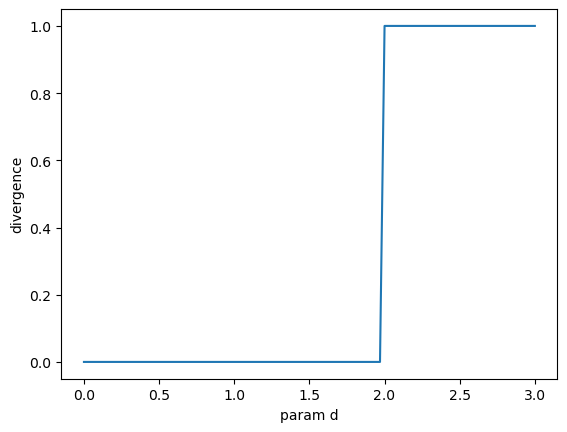

In [288]:
a = 14
b = 2
c = 2

d_space = np.linspace(0, 3, 100)
convergence = np.zeros(100, dtype=np.bool)

for i, d in enumerate(d_space):
    x = solve_disc(cobweb_model(a,b,c,d), x0, 400)
    convergence[i] = converges(x[:, 0])

plt.plot(d_space, convergence)
plt.xlabel("param d")
plt.ylabel("divergence")
plt.show()

In [289]:
behavior_change = d_space[np.argmax(convergence > 0.5)]

print(f"El cambio de comportamiento ocurre alrededor de d = {behavior_change:.1f}")

El cambio de comportamiento ocurre alrededor de d = 2.0


**(b)** Ahora se asume el caso de *backward looking average expectation*, esto es, los productores fijan las expectativas de los precios de acuerdo a una media ponderada de los precios en los dos periodos anteriores: 

  $$ p_t^e= (1-\alpha) p_{t-1} + \alpha p_{t-2}. $$

Dados los precios iniciales $p_1=2$ y $p_0=1$, y los mismos valores de los parámetros que en el apartado anterior, $a=14$, $b=2$, $c=2$ y $d>0$, con $\alpha=0.5$, encontrar el valor de $d$ para que el comportamiento de los precios a largo plazo pase de ser convergente a divergente. Realizar un heatmap con los valores de $\alpha$ y $d$ diferenciando entre regiones convergentes, oscilantes y divergentes a largo plazo.

In [171]:
def cobweb_lookback(alpha, a, b, c, d):
    def f(xs):
        pt1 = xs[-1, 0]
        pt2 = xs[-2, 0]

        pte = (1-alpha)*pt1 + alpha * pt2

        return np.array([(a-c)/b - d*pte/b])
    return f

def solve_strong_disc(model, x0s, n):
    init_len, num_vars = x0s.shape
    x = np.zeros((n, num_vars))
    x[:init_len,:] = x0s
    for i in range(init_len-1, n-1):
        x[i+1] = model(x[:i+1])
    return x

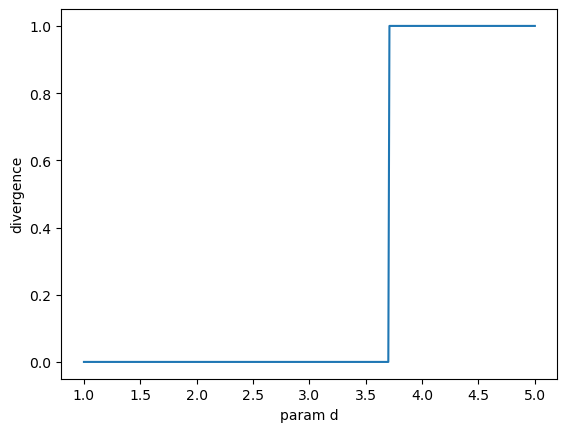

In [290]:
a = 14
b = 2
c = 2

alpha = 0.5

x0s = np.array([[1], [2]])

d_space = np.linspace(1, 5, 401)
convergence = np.zeros(401, dtype=np.bool)

for i, d in enumerate(d_space):
    x = solve_strong_disc(cobweb_lookback(alpha, a, b, c, d), x0s, 100)
    convergence[i] = converges(x)


plt.plot(d_space, convergence)
plt.xlabel("param d")
plt.ylabel("divergence")
plt.show()

In [291]:
behavior_change = d_space[np.argmax(convergence > 0.5) - 1]

print(f"el cambio de comportamiento ocurre alrededor de d = {behavior_change:.1f}")

el cambio de comportamiento ocurre alrededor de d = 3.7


In [319]:
alpha_space = np.linspace(0, 1, 101)
d_space = np.linspace(0, 10, 101)

res = np.zeros((101, 101))
for i, alpha in enumerate(alpha_space):
    for j, d in enumerate(d_space):
        x = solve_strong_disc(cobweb_lookback(alpha, a, b, c, d), x0s, 100)
        res[i, j] = converges(x)

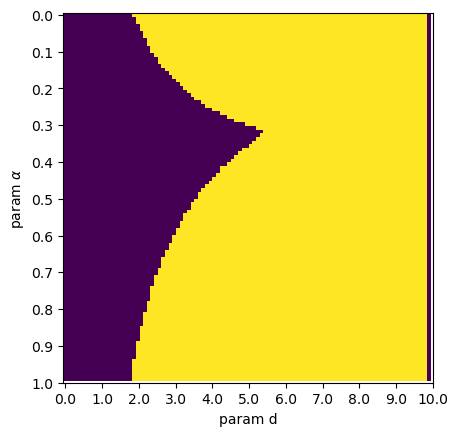

In [323]:
plt.imshow(res)
plt.xlabel("param d")
plt.ylabel(r"param $\alpha$")
plt.xticks(np.linspace(0, 101, 11), [f"{tick:.1f}" for tick in d_space[::10]])
plt.yticks(np.linspace(0, 101, 11), [f"{tick:.1f}" for tick in alpha_space[::10]])
plt.show()

**(c)** Tomar el modelo del apartado (b) alargando los periodos que se toman para estimar precios. O sea, la expectativa de precios en el tiempo $t$ es la media ponderada de los precios $p_{t-1}$, $p_{t-2}$ y $p_{t-3}$. El precio más alejado tiene un ponderación de $\alpha$ y los otros dos se reparten a partes iguales el resto de la ponderación $1-\alpha$. Dados los precios iniciales $p_2=2$ y $p_1=1$ y $p_0=1$, realizar un heatmap con los valores de $\alpha$ y $d$ diferenciando entre regiones convergentes, oscilantes y divergentes a largo plazo. 

In [303]:
def cobweb_lookback_n(alpha, a, b, c, d, n):
    def f(xs):
        pt_furthest = xs[-n, 0]
        pt_other = xs[-n+1:, 0]
        pte = alpha * pt_furthest + (1-alpha) * pt_other.sum() / (n-1)
        return np.array([(a-c)/b - d*pte/b])
    return f

In [328]:
from tqdm.notebook import tqdm
x0s = np.array([[1], [1], [2]])

res = np.zeros((101, 101))

with tqdm(total=101*101) as pbar:
    for i, alpha in enumerate(alpha_space):
        for j, d in enumerate(d_space):
            x = solve_strong_disc(cobweb_lookback_n(alpha, a, b, c, d, 3), x0s, 500)
            res[i, j] = converges(x)
            pbar.update()

  0%|          | 0/10201 [00:00<?, ?it/s]

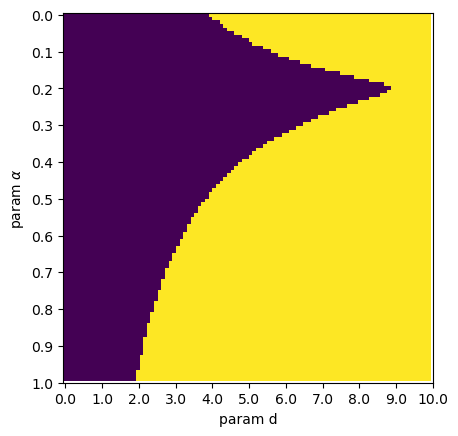

In [329]:
plt.imshow(res)
plt.xticks(np.linspace(0, 101, 11), [f"{tick:.1f}" for tick in d_space[::10]])
plt.yticks(np.linspace(0, 101, 11), [f"{tick:.1f}" for tick in alpha_space[::10]])
plt.xlabel("param d")
plt.ylabel(r"param $\alpha$")
plt.show()

**(d)** Analizar el efecto del incremento de periodos que se toman para estimar precios $N$ sobre los valores umbrales de convergencia para el parámetros $d$. O sea, fijado $\alpha=0.5$ la ponderación el precio más alejado y el resto de las ponderaciones iguales, realizar una gráfica que relacione $N$ con el parámetro $d$ y que indique umbrales de convergencia.

In [310]:
alpha = 0.5

n_space = np.linspace(2, 10, 9)

res = np.zeros((101, 9))
for i, d in enumerate(d_space):
    for j, n in enumerate(n_space):
        n = int(n)
        x0s = np.zeros((n, 1))
        for ni in range(n):
            x0s[ni,0] = 1
        x = solve_strong_disc(cobweb_lookback_n(alpha, a, b, c, d, n), x0s, 300)
        res[i, j] = converges(x)


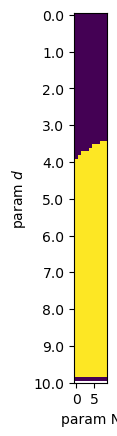

In [317]:
plt.imshow(res)
plt.yticks(np.linspace(0, 101, 11), d_space[::10])
plt.xlabel("param N")
plt.ylabel("param $d$")
plt.show()

estudiando $N$ entre 2 y 10, se observa que el parametro $d$ es más impactante, con un umbral situado generalmente entre $3.5$ y $4$